In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
from pathlib import Path
import time
import math
from typing import Union
import os
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm
import nvdiffrast.torch as dr
import matplotlib.pyplot as plt
import tree_segmentation as ts
from semantic_sam import semantic_sam_l
import torch_geometric as pyg
from tree_segmentation.extension import Mesh, ops_3d, utils
from tree_segmentation import Tree2D, Tree3Dv2, Tree3D
import open3d as o3d
import struct

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
device = torch.device('cuda')
torch.set_grad_enabled(False)
glctx = dr.RasterizeCudaContext()

2.0.0+cu117


In [3]:
mesh_path = Path('~/data/meshes/winter_scene/low_poly_winter_scene.obj').expanduser().resolve()
print('mesh path:', mesh_path)
cache_dir = Path(f'./results/{ts.get_hash_name(mesh_path)}')
print('cache dir:', cache_dir)

mesh path: /home/wan/data/meshes/winter_scene/low_poly_winter_scene.obj
cache dir: results/f18abdf8888895cc312fc27a7f064ce7


In [4]:
cache_file = cache_dir.joinpath(mesh_path.name).with_suffix('.mesh_cache')
if cache_file.exists() and 1:
    mesh = torch.load(cache_file, map_location=device)  # type: Mesh
else:
    mesh = Mesh.load(mesh_path)
    mesh.float()
    mesh.int()
    mesh = mesh.unit_size()
    # mesh_ = mesh.to_open3d()
    # print(mesh_)
    # mesh_smp = mesh_.simplify_quadric_decimation(target_number_of_triangles=500_000, maximum_error=0.1)
    # mesh_smp = mesh_.simplify_vertex_clustering(target_number_of_triangles=500_000, maximum_error=0.5)
    # o3d.io.write_triangle_mesh(cache_dir.joinpath('simplified.ply').as_posix(), mesh_smp)
    # mesh = mesh.from_open3d(mesh_smp).cuda().unit_size()
    # print(mesh)
    mesh = mesh.cuda().unit_size()
    cache_dir.mkdir(exist_ok=True)
    torch.save(mesh, cache_file)
    print('save cached mesh to', cache_file)
mesh.compute_tangents_()
print(mesh)

Mesh(vertices=133234, faces=66051, tex, nrm, tng, mat=['name', 'ka', 'bsdf', 'kd', 'ks'])


# 2D Rendering and Segmentation

In [13]:
N = 100
# 球面上的均匀格点
# seq = torch.arange(N, device=device)
# c = (math.sqrt(5) - 1) * math.pi
# z = ((seq * 2 - 1) / N - 1).clamp(-1, 1)
# x = torch.sqrt(1 - z * z) * (seq * c).cos()
# y = torch.sqrt(1 - z * z) * (seq * c).sin()
# eye = torch.stack([x, y, z], dim=-1) * 2.5
# eye = eye * (torch.ones((N, 1), device=device))  # * (radius_range[1] - radius_range[0]) + radius_range[0])
# 随机采点
phi_range = [0, math.pi * 2.]
cos_theta_range = [math.cos(0), math.cos(math.pi*0.5)]
phis = torch.rand((N,), device=device) * (phi_range[1] - phi_range[0]) + phi_range[0]
thetas = torch.arccos(torch.rand((N,), device=device) * (cos_theta_range[1] - cos_theta_range[0]) + cos_theta_range[0])
radius = torch.full((N,), 1.8, device=device)
eye = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
Tw2vs = ops_3d.look_at(eye, torch.zeros_like(eye))
print(utils.show_shape(Tw2vs))

F32Tensor[100, 4, 4]


F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024]


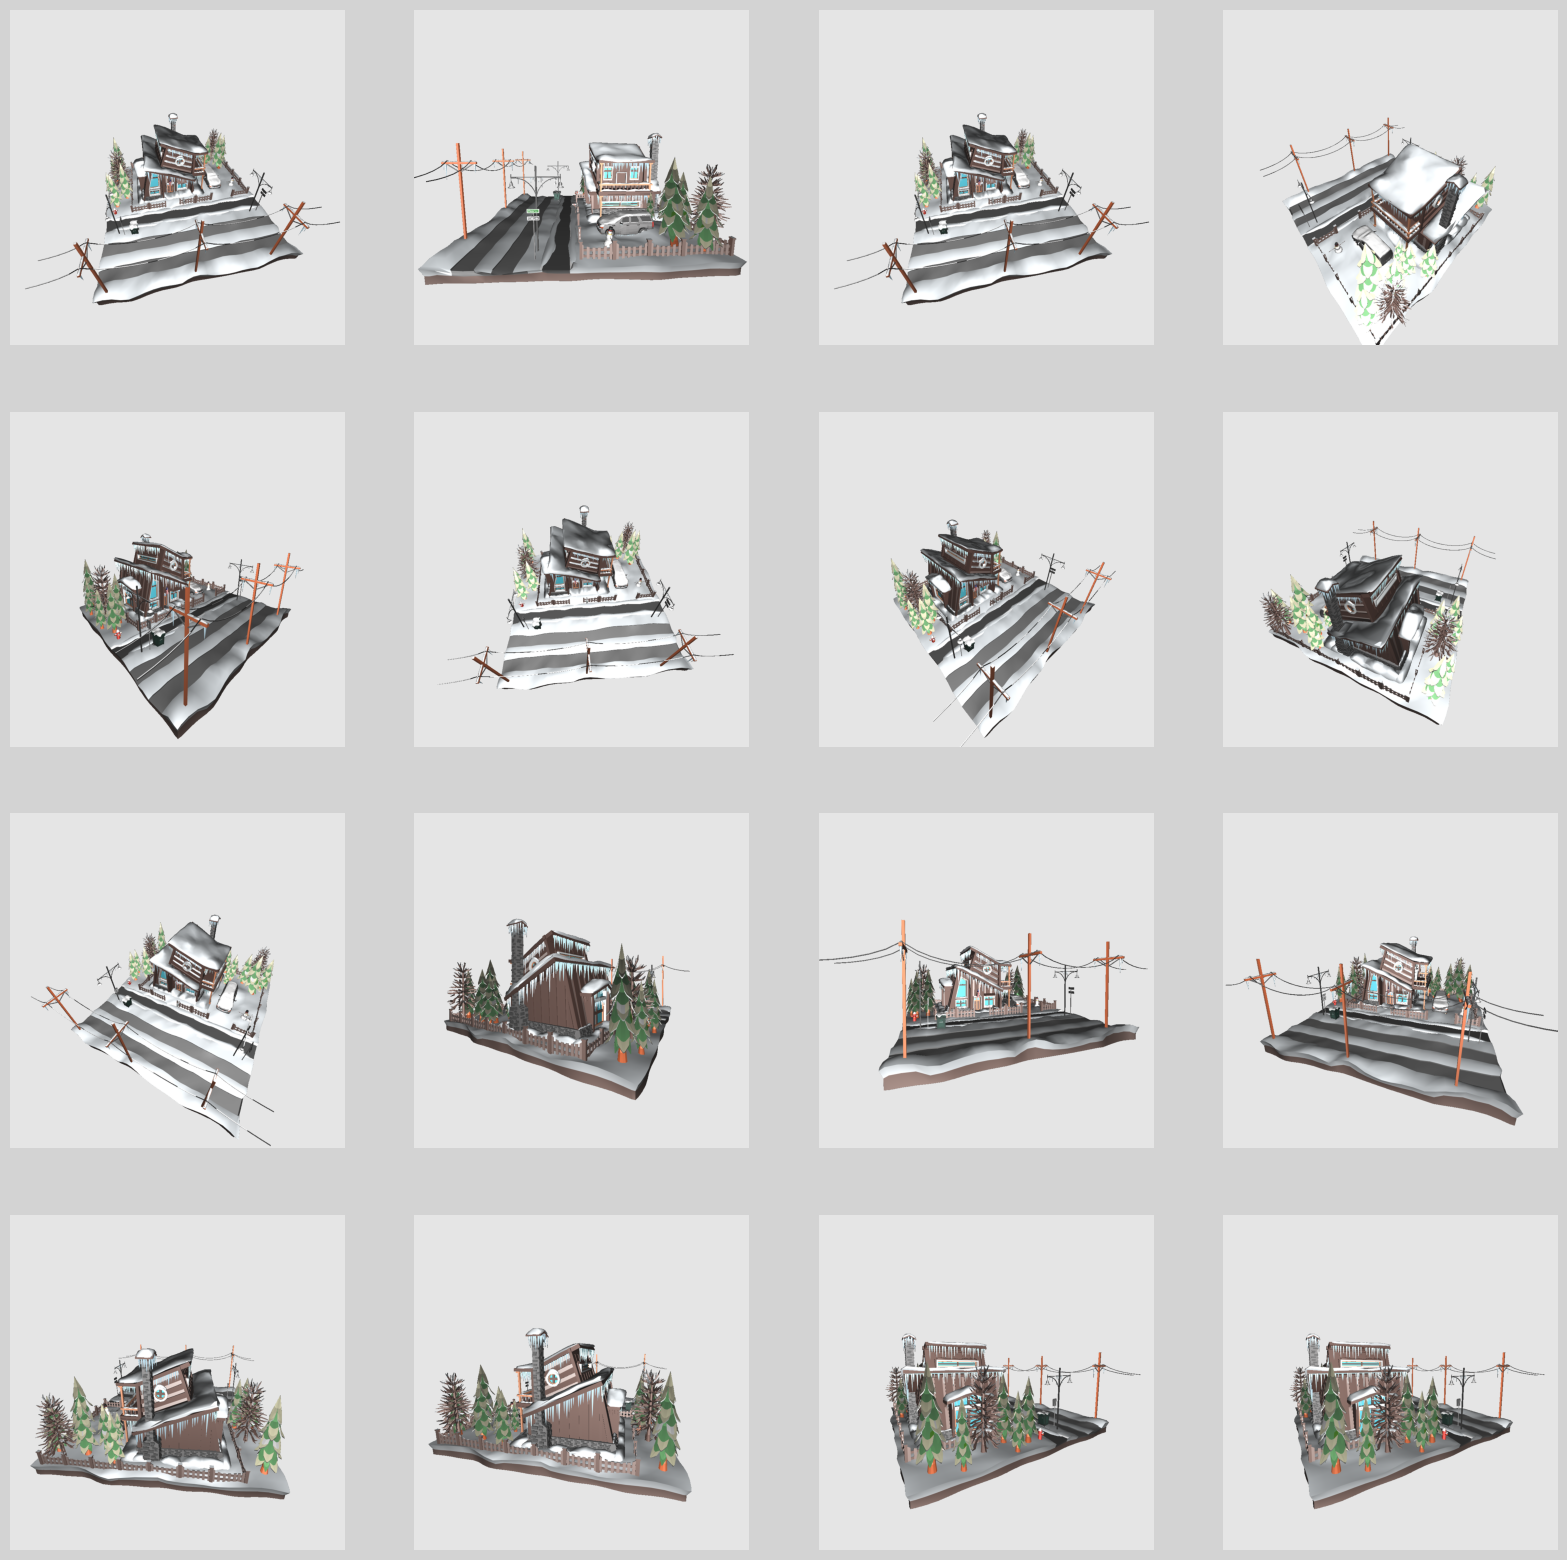

In [14]:
image_size = 1024
images, tri_ids = [], []
for i in range(0, N, 10):
    images_i, tri_ids_i = ts.render_mesh(
        glctx, mesh, Tw2v=Tw2vs[i:i + 10], image_size=image_size, fovy=math.radians(90), background=0.9)
    images.append(images_i.cpu())
    tri_ids.append(tri_ids_i.cpu())
images, tri_ids = torch.cat(images), torch.cat(tri_ids)
print(utils.show_shape(images, tri_ids))
plt.figure(figsize=(20, 20), facecolor='lightgray')
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    # plt.imshow(images[i].cpu().numpy())
    plt.imshow(images[np.random.randint(0, N)].cpu().numpy())
    plt.axis('off')

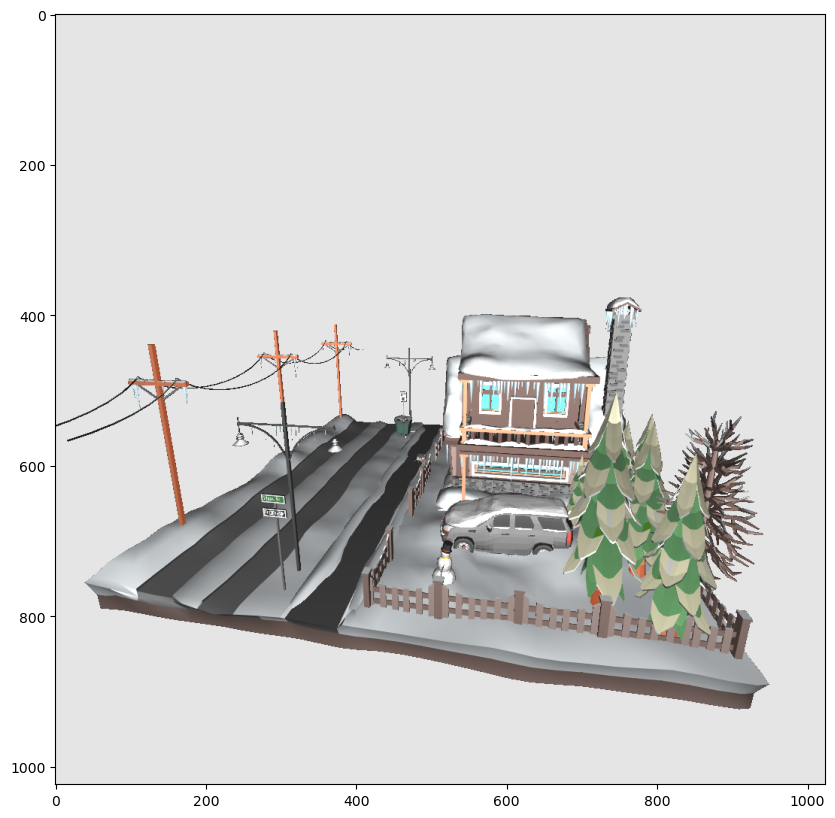

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0].cpu().numpy())

# 2D Segmentation

In [16]:
print(utils.get_GPU_memory())
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().to(device)
predictor = ts.TreePredictor(model)
print(utils.get_GPU_memory())

(2.151454448699951, 31.7391357421875)
(1.0131196975708008, 31.7391357421875)


image: F32Tensor[1024, 1024, 3]
(3.149202823638916, 31.7391357421875)
(1.142031192779541, 31.7391357421875)


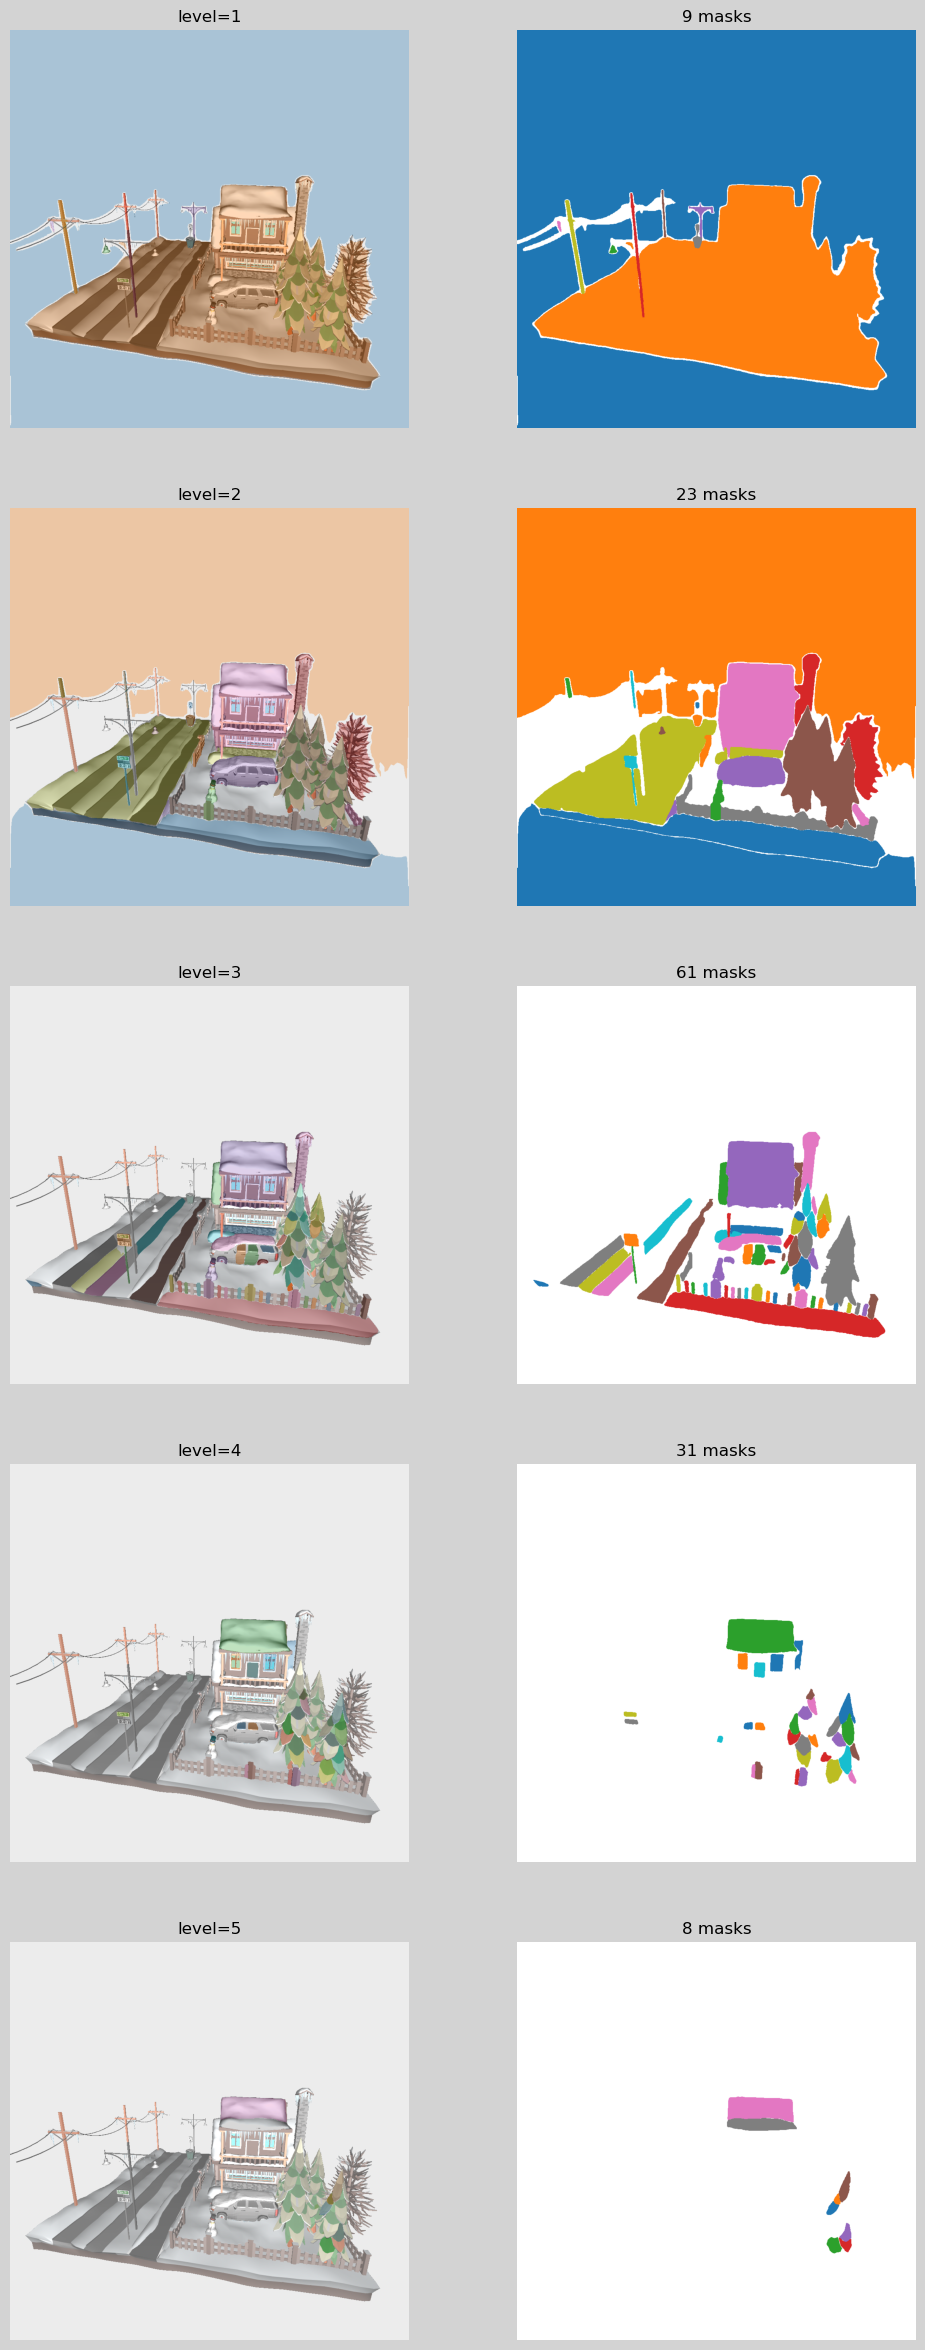

In [17]:
show_index = 0
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.tree_generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_steps=100,
    in_threshold=0.8,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
ts.show_all_levels(image, tree_data, facecolor='lightgray', width=6)
print(utils.get_GPU_memory())
del tree_data
torch.cuda.empty_cache()
print(utils.get_GPU_memory())

In [19]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(N)):
    if cache_dir.joinpath(f"view_{index:04d}.data").exists():
        continue
    tree_data = predictor.tree_generate(
        (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
        max_steps=100,
        in_threshold=0.8,
        union_threshold=0.1,
        min_mask_region_area=100,
        points_per_update=256,
        device=device,
        in_thre_area=50,
    )
    data = {
        'tree_data': tree_data.save(filename=None),
        'tri_id': tri_ids[index].clone(),
        'image': images[index].clone(),
        'Tw2v': Tw2vs[index].clone(),
    }
    torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:09:34<00:00, 41.74s/it]


# 3D Segmentation

In [5]:
tree3d = Tree3Dv2(mesh, device=device, verbose=1)
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir, pack=False)
print(tree3d.masks_2d.shape)

[Tree] reset
[Tree3D] GPU: (0.023415565490722656, 31.7391357421875)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'parent': IntTensor[135], 'first': IntTensor[135], 'next': IntTensor[135], 'last': IntTensor[135], 'cnt': 134, 'num_samples': IntTensor[135], 'masks': IntTensor[5, 1024, 1024], 'scores': F16Tensor[134], 'extra': {}}, 'tri_id': IntTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 3], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] GPU: (0.010832786560058594, 31.7391357421875)
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 66052], (IntTensor[10205], LongTensor[10205])
[Tree3D] loaded 100 views, 7768 masks, max_num: 153
[Tree3D] GPU: (5.084889888763428, 31.7391357421875)
torch.Size([7768, 66052])


In [6]:
# Gv = tree3d.build_view_graph()
# Gm = tree3d.build_graph(Gv)
A = tree3d.build_all_graph()
X, autoencoder = tree3d.compress_masks(epochs=3000)
print(autoencoder)
print(utils.get_GPU_memory())

[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.710, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.155, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.028, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.023, lr=9.754e-04
[Tree3D] X epoch[ 400], loss: recon= 0.021, lr=9.566e-04
[Tree3D] X epoch[ 500], loss: recon= 0.017, lr=9.328e-04
[Tree3D] X epoch[ 600], loss: recon= 0.015, lr=9.043e-04
[Tree3D] X epoch[ 700], loss: recon= 0.014, lr=8.714e-04
[Tree3D] X epoch[ 800], loss: recon= 0.013, lr=8.343e-04
[Tree3D] X epoch[ 900], loss: recon= 0.012, lr=7.937e-04
[Tree3D] X epoch[1000], loss: recon= 0.012, lr=7.498e-04
[Tree3D] X epoch[1100], loss: recon= 0.011, lr=7.032e-04
[Tree3D] X epoch[1200], loss: recon= 0.010, lr=6.544e-04
[Tree3D] X epoch[1300], loss: recon= 0.010, lr=6.038e-04
[Tree3D] X epoch[1400], loss: recon= 0.009, lr=5.522e-04
[Tree3D] X epoch[1500], loss: recon= 0.009, lr=5.000e-04
[Tree3D] X epoch[1600], loss:

In [8]:
K = tree3d.Lmax * 10
gnn = pyg.nn.GCN(in_channels=X.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').cuda()
print(gnn)
tree3d.run(epochs=10000, K=K, gnn=gnn, A=A * A.ge(0.5), X=X)
tree3d.save(cache_dir.joinpath('my.tree3dv2'))

GCN(256, 1530, num_layers=2)
[Tree3D] GPU: (5.263526916503906, 31.7391357421875)
[Tree3D] GPU: (3.8747291564941406, 31.7391357421875)
[Tree3D] Epoch 100: loss=1.814501, recon= 0.004, match= 0.887, vm= 0.879, mv= 0.016, tree= 0.007
[Tree3D] Epoch 200: loss=1.739605, recon= 0.004, match= 0.739, vm= 0.763, mv= 0.024, tree= 0.005
[Tree3D] Epoch 300: loss=1.673048, recon= 0.004, match= 0.653, vm= 0.699, mv= 0.027, tree= 0.005
[Tree3D] Epoch 400: loss=1.474176, recon= 0.003, match= 0.605, vm= 0.657, mv= 0.028, tree= 0.005
[Tree3D] Epoch 500: loss=0.962128, recon= 0.004, match= 0.559, vm= 0.622, mv= 0.029, tree= 0.004
[Tree3D] Epoch 600: loss=0.895983, recon= 0.004, match= 0.552, vm= 0.618, mv= 0.030, tree= 0.004
[Tree3D] Epoch 700: loss=1.174424, recon= 0.004, match= 0.561, vm= 0.622, mv= 0.032, tree= 0.004
[Tree3D] Epoch 800: loss=0.787093, recon= 0.004, match= 0.525, vm= 0.597, mv= 0.032, tree= 0.004
[Tree3D] Epoch 900: loss=1.308120, recon= 0.004, match= 0.512, vm= 0.586, mv= 0.032, tree=

In [ ]:
show_index = 8
ts.show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()

In [10]:
# metric = ts.TreeSegmentMetric()
# metric.update(tree3d.to(device), gt_v2.to(device))
# print(metric.summarize(), metric.gt_iou_sum / metric.cnt)
tree3d = Tree3Dv2(mesh, device)
tree3d.load(cache_dir.joinpath('my.tree3dv2'))

[Tree3D] load results from: results/dfa19da2d68639883ce9f71be79210a5/my.tree3dv2


In [12]:
print(tree3d.num_faces)
print(utils.show_shape(tree3d.masks))
print(utils.show_shape(tree3d.scores))
# show_index = 8
# ts.show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])

499999
BoolTensor[400, 100000]
F32Tensor[400]
